In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from autoencoder.modules.model import VAE
from autoencoder.modules.data import MSA_Dataset

## Inspect the pre-processed MSA

In [77]:
MSA_id = "COG28-l100-s2.0-aNone"
data_path = f"msas/coupling_sims/processed/1250/{MSA_id}"

## Load data and instantiate dataset

In [78]:
# read in binary representation of MSA
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([1245, 100, 21])

In [80]:
# each sequence has a label
with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
    seq_names = pickle.load(file_handle)
print(len(seq_names))
print(seq_names[:5])

1245
['N797', 'N1', 'N413', 'N829', 'N975']


In [81]:
# weight equally
seq_weight = np.ones(n_seq) / n_seq
seq_weight = seq_weight.astype(np.float32)

In [82]:
data = MSA_Dataset(msa_binary, seq_weight, seq_names)
# Show a random example
data[1000]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 0.00080321287,
 'N85')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [83]:
# Default num_hidden_units: [256, 256]
model = VAE(nl=nl, nc=nc, dim_latent_vars=2)

Let's check that our model processes data the way we want it to

In [69]:
# Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
# Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim=1))

Mean and variance of latent vector:
(tensor([[ 0.0331, -0.0482]], grad_fn=<AddmmBackward0>), tensor([[0.9923, 0.9882]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 100, 21]) and is given by:
tensor([[[-3.0818, -2.9577, -3.0454,  ..., -3.1068, -2.9373, -3.0015],
         [-2.9663, -3.0389, -2.9359,  ..., -3.1378, -3.1028, -3.1372],
         [-3.1495, -3.0630, -3.0533,  ..., -3.0469, -3.0838, -3.1706],
         ...,
         [-3.0703, -2.9950, -3.0855,  ..., -3.0373, -2.8778, -3.1118],
         [-2.9957, -3.0754, -3.1403,  ..., -2.9676, -3.1320, -3.0075],
         [-3.0620, -3.0071, -3.1296,  ..., -3.0870, -3.0083, -3.0750]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0459, 0.0519, 0.0476,  ..., 0.0447, 0.0530, 0.0497],
        [0.0515, 0.0479, 0.0531,  ..., 0.0434, 0.0449, 0.0434],
        [0.0429, 0.0467, 0.0472,  ..., 0.0475, 0.0458, 0.0420],
        ...,
        [0.0464, 0.0500, 0.0457,  ..., 0.0480,

## Train model

In [70]:
def train(model, device, train_loader, optimizer, epoch, verbose):
    """
    Define how to do an epoch of training    
    """
    model.train()
    running_elbo = []

    for batch_idx, (msa, weight, _) in enumerate(train_loader):
        msa, weight = msa.to(device), weight.to(device)
        optimizer.zero_grad()
        elbo, _ = model.compute_weighted_elbo(msa, weight)
        loss = (-1)*elbo
        loss.backward()
        optimizer.step()
        elbo_scalar = elbo.item()
        if verbose:
            print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, elbo_scalar),
                  flush=True)
        running_elbo.append(elbo_scalar)

    return running_elbo

def eval(model, device, valid_loader, n_samples = 1000):
    """
    Define how to do an epoch of evaluation
    """
    model.eval()
    elbos = []
    log_pxgzs = []
    elbo_iwaes = []

    with torch.no_grad():
        for (msa, weight, _) in valid_loader:
            msa = msa.to(device)
            # compute elbo loss with normal elbo
            elbo, log_pxgz = model.compute_weighted_elbo(msa, weight)
            elbos.append(elbo.item())
            log_pxgzs.append(log_pxgz.item())

            # compute elbo loss with iwae elbo
            all_iwae_elbos = model.compute_iwae_elbo(msa, n_samples)
            ave_iwae_elbos = torch.mean(all_iwae_elbos).item()
            elbo_iwaes.append(ave_iwae_elbos)

    return elbos, log_pxgzs, elbo_iwaes

In [71]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyperparameters
num_epochs = 500
wd = 1e-5
dim_lat = 10
num_hidden_units = [256, 256]
n_samples = 100
bs = 128
verbose = False

cpu


In [57]:
# set up data loaders
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(
    range(len(data)), test_size=0.1, random_state=42)
train_loader = DataLoader(
    data, batch_size=bs, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
valid_loader = DataLoader(
    data, batch_size=bs, sampler=torch.utils.data.SubsetRandomSampler(test_idx))

In [72]:
model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat, num_hidden_units=num_hidden_units).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=wd)

train_elbos = []
val_elbos = []
val_log_pxgzs = []
val_elbo_iwaes = []
for epoch in range(num_epochs):
    #Validation metrics
    val_elbos_on_batches, val_log_pxgzs_on_batches, val_elbo_iwae_on_batches = eval(
        model, device, valid_loader, n_samples)
    epoch_val_elbo = np.mean(val_elbos_on_batches)
    epoch_val_log_pxgz = np.mean(val_log_pxgzs_on_batches)
    epoch_val_elbo_iwae = np.mean(val_elbo_iwae_on_batches)
    val_elbos.append(epoch_val_elbo)
    val_log_pxgzs.append(epoch_val_log_pxgz)
    val_elbo_iwaes.append(epoch_val_elbo_iwae)
    print(f"Validation elbo for epoch {epoch}: {epoch_val_elbo}")
    #Training metrics
    batch_elbos = train(model, device, train_loader, optimizer, epoch, verbose)
    epoch_train_elbo = np.mean(batch_elbos)
    train_elbos.append(epoch_train_elbo)
    print(f"Training elbo for epoch {epoch}: {epoch_train_elbo}")

Validation elbo for epoch 0: -305.18280029296875
Training elbo for epoch 0: -286.7051357693142
Validation elbo for epoch 1: -250.11170959472656
Training elbo for epoch 1: -242.26346842447916
Validation elbo for epoch 2: -236.99575805664062
Training elbo for epoch 2: -235.09122551812067
Validation elbo for epoch 3: -234.29116821289062
Training elbo for epoch 3: -233.5960456000434
Validation elbo for epoch 4: -232.9419708251953
Training elbo for epoch 4: -231.5370076497396
Validation elbo for epoch 5: -231.73590087890625
Training elbo for epoch 5: -230.41707695855035
Validation elbo for epoch 6: -231.29678344726562
Training elbo for epoch 6: -229.30651177300348
Validation elbo for epoch 7: -229.71719360351562
Training elbo for epoch 7: -226.64664204915366
Validation elbo for epoch 8: -226.2098388671875
Training elbo for epoch 8: -222.48227776421442
Validation elbo for epoch 9: -222.11700439453125
Training elbo for epoch 9: -218.57790289984808
Validation elbo for epoch 10: -219.0032043457

In [76]:
# Save model
from datetime import date
import os
os.makedirs(f"saved_models/{MSA_id}", exist_ok=True)
model.cpu()
today = date.today()
layers = "-".join([str(l) for l in num_hidden_units])
torch.save(model.state_dict(),
           "model.pt")
# Save test indices
with open("test_idx.pkl", 'wb') as file_handle:
    pickle.dump(test_idx, file_handle)

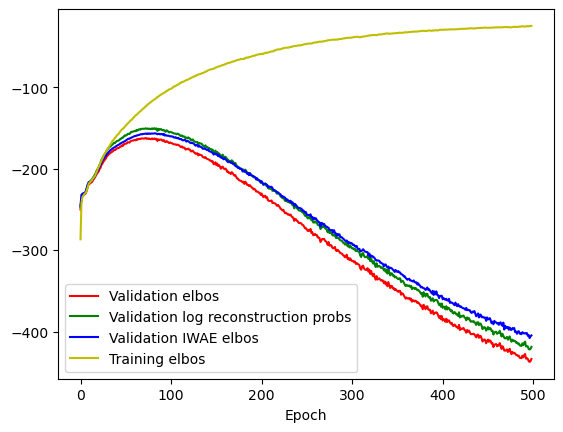

In [73]:
plt.plot(val_elbos[1:], label="Validation elbos", color='r')
plt.plot(val_log_pxgzs[1:], label="Validation log reconstruction probs", color='g')
plt.plot(val_elbo_iwaes[1:], label="Validation IWAE elbos", color='b')
plt.plot(train_elbos[:-1], label="Training elbos", color='y')
plt.xlabel("Epoch")
plt.legend()

In [75]:
for batch_idx, (msa, weight, _) in enumerate(train_loader):
    acc = model.compute_acc(msa)
    ave_acc = torch.mean(acc).item()
    print(f"Accuracy on batch {batch_idx} is {ave_acc}")

Accuracy on batch 0 is 0.9875781536102295
Accuracy on batch 1 is 0.9861719012260437
Accuracy on batch 2 is 0.9857031106948853
Accuracy on batch 3 is 0.9844531416893005
Accuracy on batch 4 is 0.987109363079071
Accuracy on batch 5 is 0.9883594512939453
Accuracy on batch 6 is 0.9872657060623169
Accuracy on batch 7 is 0.9872656464576721
Accuracy on batch 8 is 0.9869411587715149
